<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/BiLSTM_from_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import functional as F

In [102]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [103]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/data_10.json"

In [104]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [105]:
    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

Data succesfully loaded!


In [106]:
from torch.utils.data import TensorDataset, DataLoader

tensor_X_train = torch.Tensor(X_train)
tensor_X_val = torch.Tensor(X_val)
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)

train_dataset = TensorDataset(tensor_X_train,tensor_y_train)
val_dataset = TensorDataset(tensor_X_val,tensor_y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [107]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [108]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [109]:
def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()

In [126]:
input_dim = 13    
hidden_dim = 256
layer_dim = 2
output_dim = 10
seq_dim = 130

train_acc = []
val_acc = []

lr = 0.005
n_epochs = 200
iterations_per_epoch = len(train_dataloader)
best_acc = 0
patience, trials = 50, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
sched = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.01, max_lr=0.1)

print('Start model training')

for epoch in range(1, n_epochs + 1):

    losses = []
    tcorrect, ttotal = 0, 0
    for (x_batch, y_batch) in train_dataloader:
        model.train()
        x_batch, y_batch = [t.cuda() for t in (x_batch, y_batch)]
        y_batch = y_batch.to(torch.int64)
        opt.zero_grad()
        out = model(x_batch)

        loss = criterion(out, y_batch)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        sched.step()

        _,pred = torch.max(out, dim=1)
        ttotal += y_batch.size(0)
        tcorrect += torch.sum(pred==y_batch).item()

    train_acc.append(100 * tcorrect / ttotal)
    
    model.eval()
    vcorrect, vtotal = 0, 0
    for x_val, y_val in val_dataloader:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        vtotal += y_val.size(0)
        vcorrect += (preds == y_val).sum().item()
    
    vacc = vcorrect / vtotal
    val_acc.append(vacc*100)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Val Acc.: {vacc:2.2%}')

    if vacc > best_acc:
        trials = 0
        best_acc = vacc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with val accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch 1 best model saved with val accuracy: 41.28%
Epoch:   5. Loss: 1.7932. Val Acc.: 42.35%
Epoch 5 best model saved with val accuracy: 42.35%
Epoch 6 best model saved with val accuracy: 45.12%
Epoch 7 best model saved with val accuracy: 47.15%
Epoch 9 best model saved with val accuracy: 48.32%
Epoch:  10. Loss: 1.3808. Val Acc.: 50.38%
Epoch 10 best model saved with val accuracy: 50.38%
Epoch 14 best model saved with val accuracy: 51.95%
Epoch:  15. Loss: 1.1756. Val Acc.: 44.38%
Epoch 17 best model saved with val accuracy: 55.25%
Epoch:  20. Loss: 0.7455. Val Acc.: 58.39%
Epoch 20 best model saved with val accuracy: 58.39%
Epoch 22 best model saved with val accuracy: 61.25%
Epoch:  25. Loss: 1.4152. Val Acc.: 64.85%
Epoch 25 best model saved with val accuracy: 64.85%
Epoch 28 best model saved with val accuracy: 65.42%
Epoch 29 best model saved with val accuracy: 69.49%
Epoch:  30. Loss: 0.9273. Val Acc.: 69.16%
Epoch 31 best model saved with val accuracy: 69.72

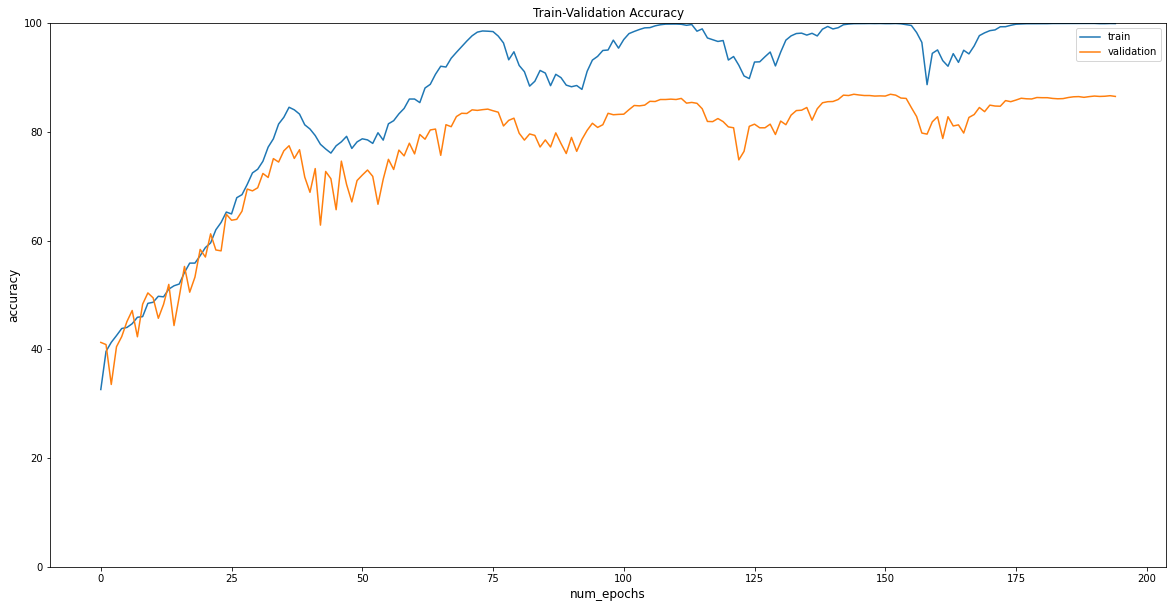

In [127]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(val_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.ylim((0,100))
#plt.xlim((0,n_epochs))

plt.legend(loc='best')

Stuff that needs tweaking

In [ ]:
import sklearn

def get_confusion_matrix(model, test_data):
    # First we make sure we disable Gradient Computing
    torch.no_grad()
    
    # Model in Evaluation Mode
    model.eval()

    preds, actuals = [], []

    for image, label in val_dataloader:
        image, label = [t.cuda() for t in (image, label)]
        #image = image.view(-1, 28, 28)
        out = model(image)

        prediction = torch.max(out, dim=1)
        preds.append(prediction)
        actuals.append(label)
    
    return sklearn.metrics.confusion_matrix(preds, actuals)

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 5))
sns.heatmap(get_confusion_matrix(model, val_dataloader), cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: LSTM', fontsize=15);



In [ ]:
model.load_state_dict(torch.load('best.pth'))

model.eval()

In [ ]:
###Needs adapting to my system

test_acc = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

